# Variational Autoencoders

As great and useful as GANs are, they have some weaknesses, particularly after the network is trained, and to not put too fine a point on it:

1. GANs are trained to generate images using random noise. This means that the prior of the image is based on noise - you can't select features you want to see. There's no way to generate specific features unless you perform exhaustive search over the whole input-output distribution!

2. Second, a generative adversarial model only discriminates between "real" and "fake" images. There's no constraints on the output image for realism or context - for example, a requirement that an image of a cat has to look like a cat.

So we can simplify this problem to being one in which we are seeking to generate output that is more "like" its input. Problems of this kind have been a matter of interest in the machine learning community for many years, and have resulted in a number of interesting attempts to solve them. Variational Autoencoders (VAE) are among the most recent and successful of these, although unlike GANs they do not have a giant track-record of success to date due to their newness (2-3 years old) and sensitivity to architecture. 

Unlike GANs, VAEs are not some simple idea of gluing two networks together to compete with each other. The VAE requires a very special formulation relatively sensitive to starting conditions to converge - even working implementations sometimes fail to converge(!). 

The problem is posed mathematically as thus:

Consider a dataset composed of i.i.d. samples $X = \{x^{(i)}\}_{i=1}^{N}$. These data are drawn from a completely hidden process $*$:

1) $z^{(i)}$ is drawn from a posterior $p_{\theta}^{*}(z)$

2) $x{(i)}$ is drawn from a conditional distribution $p_{\theta}^{*}(x|z)$

3) We assume that the distributions $p_{\theta}^{*}(z)$ and $p_{\theta}^{*}(x|z)$ are "reasonable" and differentiable with respect to the parameter set $\theta$ and $z$ almost everywhere.

4) We only ever observe $X$

Variational Bayes algorithms are useful where:

1) The integrals required for mean-field sampling ($p_{\theta}(x) = \int\ p_{\theta}(z)p_{\theta}(x|z)dz$) are completely intractable (neural networks). Also the conditional distribution $p_{\theta}(z|x) = \dfrac{\int\ p_{\theta}(x|z)p_{\theta}(z)}{p_{\theta}(x)}$ is also completely intractable.

2) The data set is large and so optimization over the whole is unreasonable

So this is of course pretty fantastic, and the algorithm is as follows:

![algo](./images/VB_algo.png)


## Practical Implementation

The elements above imply that we need very little beyond a basic estimator that attempts to get at both $\theta$ and $\phi$ simultaneously. This can be an autoencoder, of course, which includes $\phi$ and $\theta$ in one implementation (encoder and decoder). That part is easy. 

![autoencoder](./images/AE.png)


The issue is to where we are going to stop the optimization as we are trying to optimize the autoencoder to produce samples that lie **outside its training distribution**, meaning that it must encode image reproduction sfor the **latent space**, not the **training space** - fortunately this can be found in the process that samples $\epsilon$. What we attempt to do in the VAE is estimate the breadth of the latent space $v^{*}$ by observing the behavior of the noise vector.

To do so, we add a constraint on the encoding network that forces it to generate latent vectors that roughly follow a unit gaussian distribution (other choices of this distribution can be made, depending on the needs of the model). It is this constraint that separates a variational autoencoder from a standard one. Generating new images is now easy: all we need to do is sample a **latent vector** from the unit gaussian and pass it into the decoder. More specifically, we train the network on a separate latent vector layer that functions as a model of the latent space. In a very real sense, we are creating an encoding of the latent space while training the rest of the network.

In practice, there's a tradeoff between how accurate our network can be and how close its latent variables can match the unit gaussian distribution - the sampling of the latent space is limited to how much of the actual latent space is traversed by the training set. We let the network decide the strength of the fit itself. 

The cost function includes the sum of two separate losses: the generative loss, which is a mean squared error that measures how accurately the network reconstructed the images, and a latent loss, which in this case we will set to be the [Kullback-Liebler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the distribution of the latent vectors and a unit gaussian.

In order to optimize the KL divergence, we apply a simple reparameterization trick: instead of the encoder generating a vector of real values ( the input to the decoder in a normal autoencoder), it will generate a vector of means and a vector of standard deviations.

![vae](./images/VAE_schema.png)

These two vectors are then fed into the equation:

$$ L(\theta, \phi, x^{(i)}) = \dfrac{1}{2}\sum_{j=1}^{J}(1+log((\sigma_{j}^{(i)})^{2})-(\mu_{j}^{(i)})^{2}-(\sigma_{j}^{(i)})^{2})+\dfrac{1}{L}\sum_{l=1}^{L}log p_{\theta}(x^{(i)}|z^{(i,l)})$$

As obtained in [this paper](https://arxiv.org/pdf/1312.6114.pdf). To get the loss of the overall system, where the far right term is the log-loss of the learning layer(s), as discussed above, and $\sigma$ and $\mu$ are the variance and mean vectors of the latent layer.

In [1]:
'''This script demonstrates how to build a variational autoencoder with Keras.
Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 10
epsilon_std = 1.0


Using TensorFlow backend.


The sampling process will need to be coded separately as an input function to a layer - we do this here:

In [2]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon


We will also need to build our intermediate layer taking into account the loss from both the regular learner and the mean and variance vectors

In [3]:
# Custom loss layer
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

Now we can reconstruct the architecture of the model and compile it. Here we're going to use a [Lambda](https://keras.io/layers/core/#lambda) layer to wrap the sampling function we wrote above and return it as a layer! - something that is pretty tough to do in tensorflow is trivial in Keras.

In [4]:

x = Input(shape=(original_dim,)) 
h = Dense(intermediate_dim, activation='relu')(x) # this is our "encoding layer" - sorta, notice how we don't care too much
z_mean = Dense(latent_dim)(h) # here is mu
z_log_var = Dense(latent_dim)(h) # here is sigma

# note that "output_shape" isn't necessary with the TensorFlow backend, but whatev
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) # this is the custom variational layer

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu') # this is the decoder of our hidden representation
decoder_mean = Dense(original_dim, activation='sigmoid') # this is the distribution of means of the hidden layer
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

That was easy. Now we'll train the thing on the usual dataset

In [5]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 47s - loss: 191.7551 - val_loss: 173.0808
Epoch 2/10
60000/60000 [==============================] - 48s - loss: 171.2438 - val_loss: 169.8293
Epoch 3/10
60000/60000 [==============================] - 47s - loss: 167.5244 - val_loss: 165.0621
Epoch 4/10
60000/60000 [==============================] - 47s - loss: 165.4236 - val_loss: 164.0797
Epoch 5/10
60000/60000 [==============================] - 47s - loss: 164.6110 - val_loss: 162.8428
Epoch 6/10
60000/60000 [==============================] - 48s - loss: 164.6974 - val_loss: 170.9935
Epoch 7/10
60000/60000 [==============================] - 49s - loss: 165.5314 - val_loss: 166.0844
Epoch 8/10
60000/60000 [==============================] - 48s - loss: 166.7865 - val_loss: 164.9307
Epoch 9/10
60000/60000 [==============================] - 48s - loss: 168.6633 - val_loss: 175.6545
Epoch 10/10
60000/60000 [=========================

Now we can build a quick model just to project inputs onto the latent space. You don't need to fit it, just an empty model will do the dot product

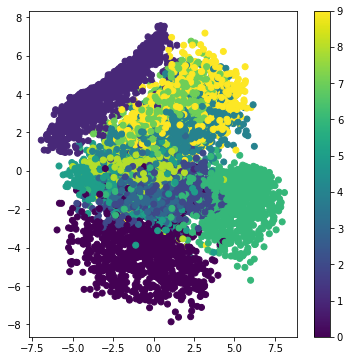

In [6]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

At this point the model has learned from the latent distribution enough that we can build another model to generate new digits from it:

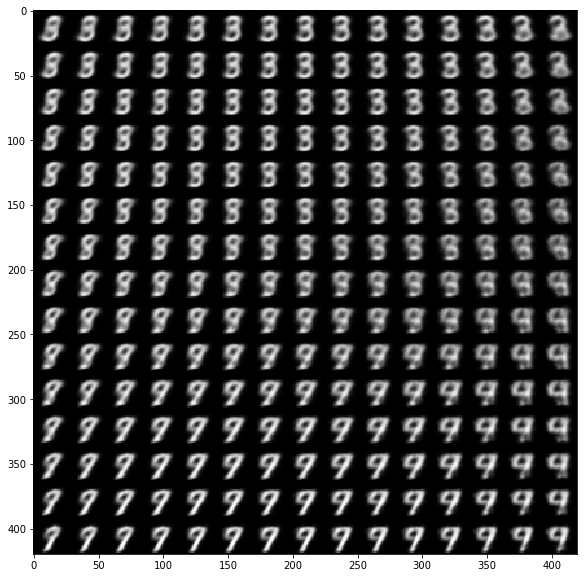

In [7]:

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input) # This is our learned latent vector
_x_decoded_mean = decoder_mean(_h_decoded) # this is the latent distribution of means (the outputs of each sample)
generator = Model(inputs=decoder_input, outputs= _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

Pretty awful. Could it be made better with [convolution?](http://docs.pymc.io/notebooks/convolutional_vae_keras_advi.html)